# Fine-tune BLIP using Hugging Face `transformers` and `datasets` 🤗

This tutorial is largely based from the [GiT tutorial](https://colab.research.google.com/drive/1HLxgrG7xZJ9FvXckNG61J72FkyrbqKAA?usp=sharing) on how to fine-tune GiT on a custom image captioning dataset. Here we will use a dummy dataset of [football players](https://huggingface.co/datasets/ybelkada/football-dataset) ⚽ that is uploaded on the Hub. The images have been manually selected together with the captions.
Check the 🤗 [documentation](https://huggingface.co/docs/datasets/image_dataset) on how to create and upload your own image-text dataset.

## Set-up environment

In [ ]:
!pip install git+https://github.com/huggingface/transformers.git@main

  Cloning https://github.com/huggingface/transformers.git (to revision main) to /tmp/pip-req-build-siovacsq
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers.git /tmp/pip-req-build-siovacsq
  Resolved https://github.com/huggingface/transformers.git to commit 3d2900e829ab16757632f9dde891f1947cfc4be0
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for transformers: filename=transformers-4.38.0.dev0-py3-none-any.whl size=8452748 sha256=2ffd6e19d9e4a2f336d09f7bb6d0878990263c821b7a8a10229722fec6f1bf3b
  Stored in directory: /tmp/pip-ephem-wheel-cache-_kii_uv9/wheels/cf/59/82/6492402e887a68975030bf8c06532260abc16abb7ccd8127cc
Successfully built transformers
  Attempting uninstall: transformers
    Found existing installation: transformers 4.35.2
    Uninstalling transformers-4.35.2:
      Successfully uninstalled transformers-4.35.2


In [ ]:
!pip install -q datasets

We also quickly upload some telemetry - this tells us which examples and software versions are getting used so we know where to prioritize our maintenance efforts. We don't collect (or care about) any personally identifiable information, but if you'd prefer not to be counted, feel free to skip this step or delete this cell entirely.

In [ ]:
from transformers.utils import send_example_telemetry

send_example_telemetry("image_captioning_blip_notebook", framework="pytorch")

## Load the image captioning dataset

Let's load the image captioning dataset, you just need few lines of code for that.

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
from datasets import load_dataset

# dataset = load_dataset("ybelkada/football-dataset", split="train")

# 03/02/24 here begins my part
dataset = load_dataset("miMel/archi_facades_3", data_dir="resized",split="train")

Let's retrieve the caption of the first example:

In [ ]:
# good it works
dataset[0]["text"]

"The house is organized on a single floor with three gabled volumes connected to each other. Installation of photovoltaic panels on right part of the gable roof allows it to cover a large part of the electricity demand. The envelope is constructed of corrugated sheet metal both on the roof and on the façade. This material offers durability and low maintenance. Building's thermal comfort is also achieved by having the windows smaller, and larger windows are covered by the roof. The house is surrounded by extensive lawn."

And the corresponding image

In [ ]:
type(dataset[0]["image"])

PIL.JpegImagePlugin.JpegImageFile

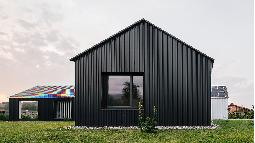

In [ ]:
dataset[0]["image"]

## Create PyTorch Dataset

The lines below are entirely copied from the original notebook!

In [ ]:
from torch.utils.data import Dataset, DataLoader

class ImageCaptioningDataset(Dataset):
    def __init__(self, dataset, processor):
        self.dataset = dataset
        self.processor = processor

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        encoding = self.processor(images=item["image"], text=item["text"], padding="max_length", return_tensors="pt")
        # remove batch dimension
        encoding = {k:v.squeeze() for k,v in encoding.items()}
        return encoding

## Load model and processor

In [ ]:
from transformers import AutoProcessor, BlipForConditionalGeneration

processor = AutoProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")

preprocessor_config.json:   0%|          | 0.00/287 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/506 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/990M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


Now that we have loaded the processor, let's load the dataset and the dataloader:

In [ ]:
train_dataset = ImageCaptioningDataset(dataset, processor)
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=2)

## Train the model

Let's train the model! Run the simply the cell below for training the model

In [ ]:
import torch

optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

model.train()

for epoch in range(50):
  print("Epoch:", epoch)
  for idx, batch in enumerate(train_dataloader):
    input_ids = batch.pop("input_ids").to(device)
    pixel_values = batch.pop("pixel_values").to(device)

    outputs = model(input_ids=input_ids,
                    pixel_values=pixel_values,
                    labels=input_ids)

    loss = outputs.loss

    print("Loss:", loss.item())

    loss.backward()

    optimizer.step()
    optimizer.zero_grad()

Epoch: 0


We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


Loss: 12.522075653076172
Loss: 11.008841514587402
Loss: 10.05538558959961
Loss: 10.109189987182617
Loss: 10.118020057678223
Loss: 10.165599822998047
Loss: 10.106428146362305
Loss: 10.068314552307129
Loss: 9.997074127197266
Loss: 10.058656692504883
Loss: 9.623146057128906
Loss: 9.786962509155273
Loss: 9.694744110107422
Loss: 9.57968807220459
Loss: 9.979656219482422
Loss: 9.709091186523438
Loss: 9.746687889099121
Loss: 9.581348419189453
Epoch: 1
Loss: 9.234086990356445
Loss: 9.053226470947266
Loss: 8.714090347290039
Loss: 8.425631523132324
Loss: 8.25023365020752
Loss: 8.073725700378418
Loss: 7.857283592224121
Loss: 7.753149509429932
Loss: 7.614137172698975
Loss: 7.491177558898926
Loss: 7.333964824676514
Loss: 7.343842506408691
Loss: 7.1289544105529785
Loss: 7.004011154174805
Loss: 6.917056083679199
Loss: 7.013667583465576
Loss: 6.712812423706055
Loss: 6.559195518493652
Epoch: 2
Loss: 6.443038463592529
Loss: 6.367456912994385
Loss: 6.310511112213135
Loss: 6.067676067352295
Loss: 6.0044360

## Inference

Let's check the results on our train dataset

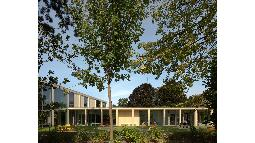

In [ ]:
# load image
example = dataset[3]
image = example["image"]
image

In [ ]:
# prepare image for the model
inputs = processor(images=image, return_tensors="pt").to(device)
pixel_values = inputs.pixel_values

generated_ids = model.generate(pixel_values=pixel_values, max_length=50)
generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
print(generated_caption)

it is a regional center for culture and leisure with environmental responsibility at its core. building consists of two pavilion - like volumes, built from cross - laminated timber. elevation clearly is wooded and has large glazing. however, the first floor


## Load from the Hub

Once trained you can push the model and processor on the Hub to use them later.
Meanwhile you can play with the model that we have fine-tuned!

In [ ]:
processor.save_pretrained("image-caption-arch")

[]

In [ ]:
model.save_pretrained("model-arch")

In [ ]:
from transformers import BlipForConditionalGeneration, AutoProcessor

model = BlipForConditionalGeneration.from_pretrained("ybelkada/blip-image-captioning-base-football-finetuned").to(device)
processor = AutoProcessor.from_pretrained("ybelkada/blip-image-captioning-base-football-finetuned")

Downloading:   0%|          | 0.00/4.72k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/990M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/431 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/488 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/712k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/125 [00:00<?, ?B/s]

In [ ]:
# my implementation
model = BlipForConditionalGeneration.from_pretrained("/content/model-arch").to(device)
processor = AutoProcessor.from_pretrained("/content/image-caption-arch")

Let's check the results on our train dataset!

In [ ]:
from matplotlib import pyplot as plt

Text(0.5, 1.0, 'Generated caption: the library building is located inside the park. a one - story volume has a roof with pergola serving as a terrace. wooden structure overhangs the ground level. the facade has concrete cladding and its windows have sunscreens.')

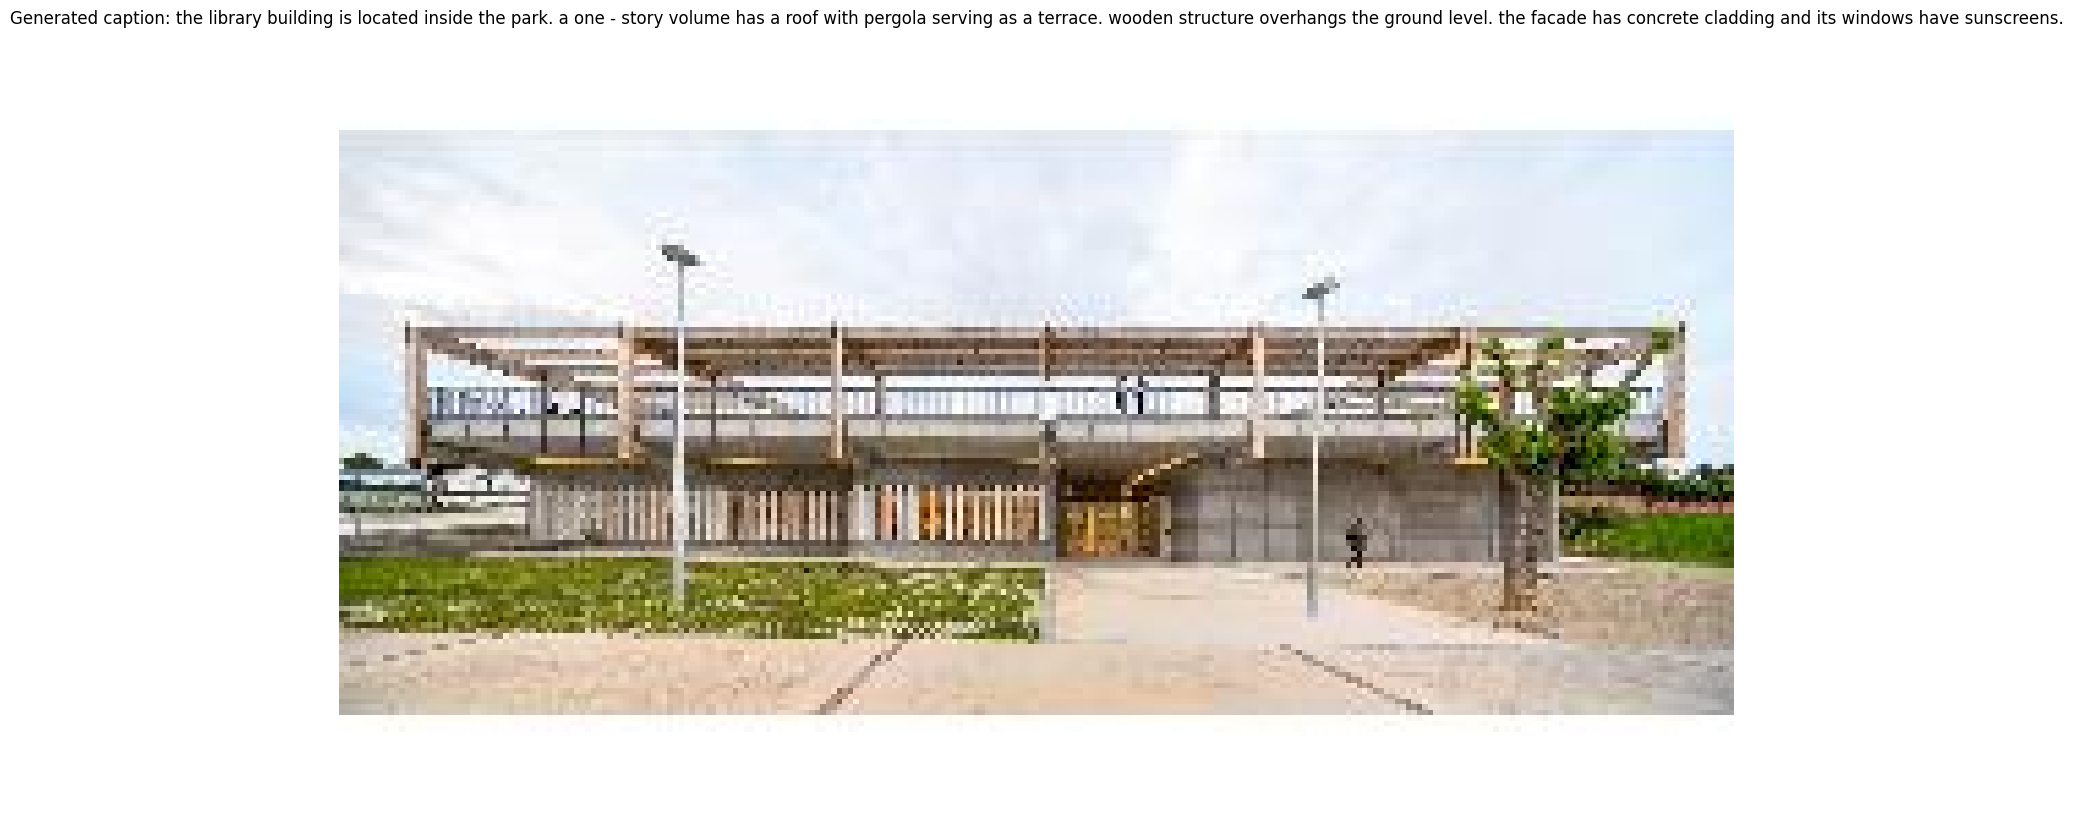

In [ ]:
fig = plt.figure(figsize=(18, 14))

image = dataset["image"][15]
inputs = processor(images=image, return_tensors="pt").to(device)
pixel_values = inputs.pixel_values

generated_ids = model.generate(pixel_values=pixel_values, max_length=50)
generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

plt.imshow(image)
plt.axis("off")
plt.title(f"Generated caption: {generated_caption}")

ValueError: num must be an integer with 1 <= num <= 6, not 7

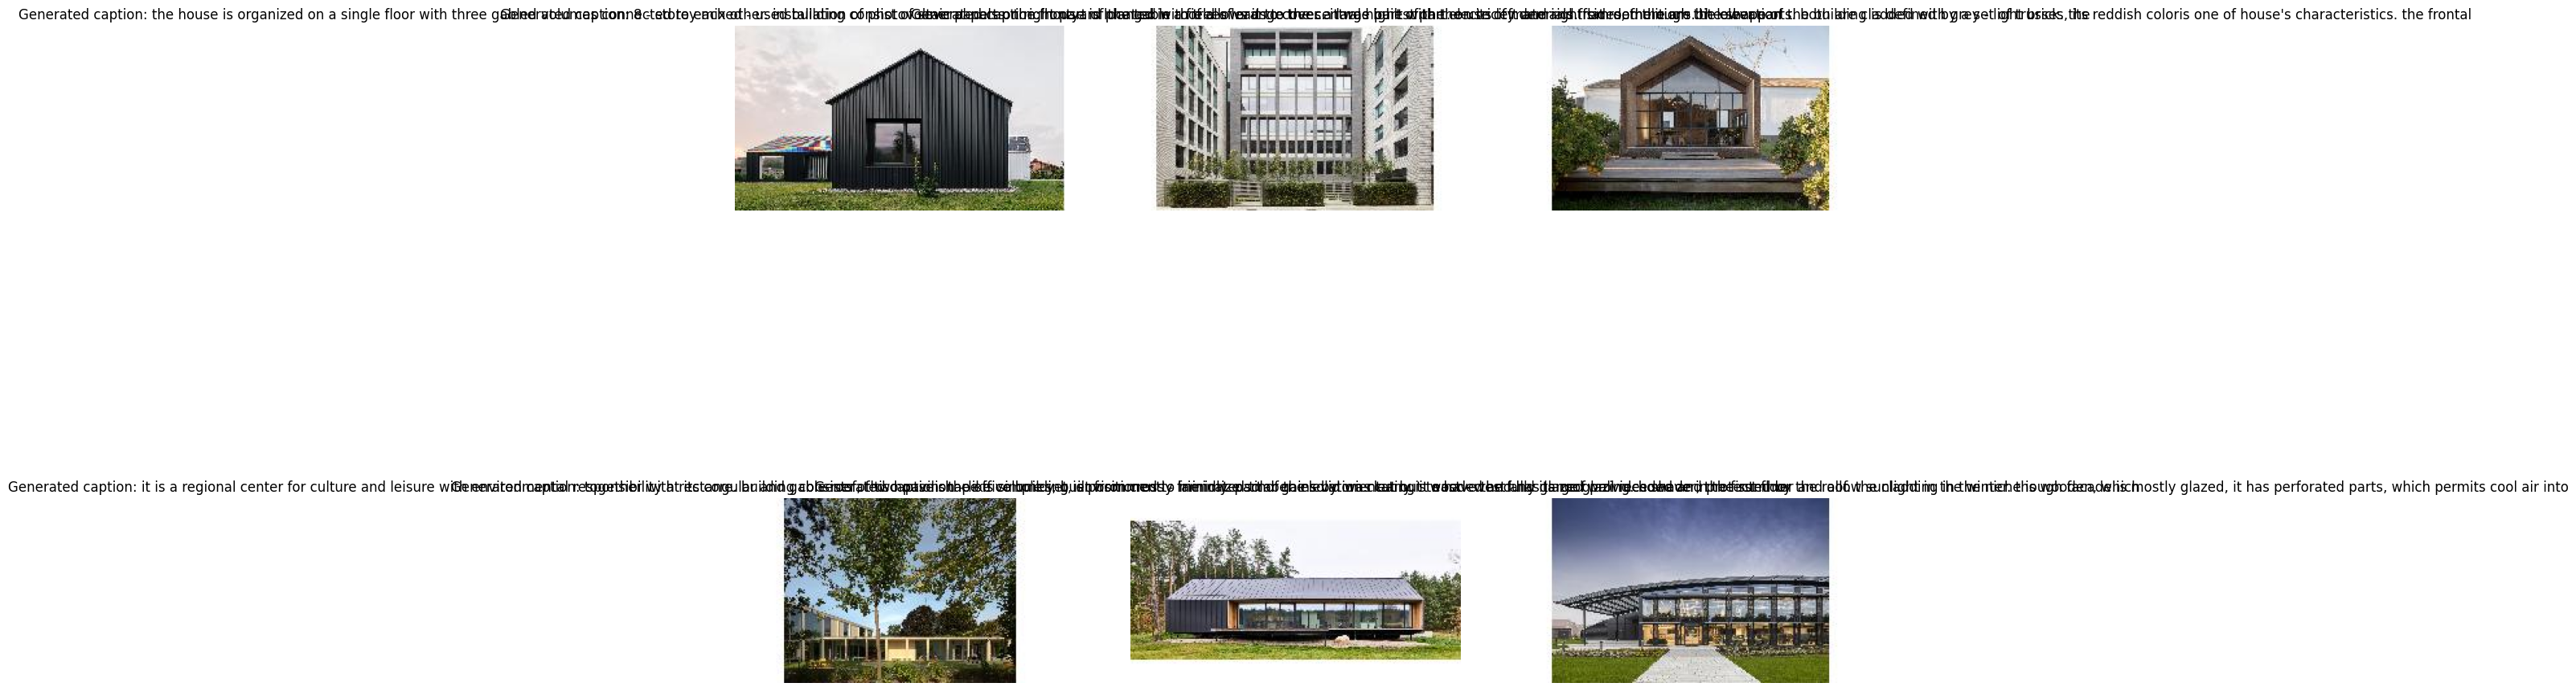

In [ ]:


fig = plt.figure(figsize=(18, 14))

# prepare image for the model
for i, example in enumerate(dataset):
  image = example["image"]
  inputs = processor(images=image, return_tensors="pt").to(device)
  pixel_values = inputs.pixel_values

  generated_ids = model.generate(pixel_values=pixel_values, max_length=50)
  generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
  fig.add_subplot(2, 3, i+1)
  plt.imshow(image)
  plt.axis("off")
  plt.title(f"Generated caption: {generated_caption}")